<a id="top"></a>
# Tutorial Title

***

## Learning Goals
By the end of this tutorial, you will:
```
- Access data from the various high-redshift HST surveys, such as GOODS and CANDELS, using astroquery
- Cross-match these with the z.MAST catalog of images, spectra and value-added products
- Make cutout images of the highest redshift candidates, which would be ideal for JWST follow-up.

```

## Introduction
The James Webb Space Telescope (JWST) is revolutionizing our understanding of the early Universe. With its unprecedented sensitivity at infrared wavelengths, it can capture starlight (which usually dominates at optical wavelengths) that has been redshifted by the expansion of the Universe by factors of 6-20. Previously, these galaxies could only be found if they were gravitationally lensed, which requires them to be aligned perfectly with more massive objects closer to us; even so, the furthest detected galaxies were at z~10. 

The richest existing catalogs of high-redshift galaxies come from deep HST surveys, which pointed at specific patches of the sky for incredibly long periods of time. These include [CANDELS](https://archive.stsci.edu/prepds/candels/), [GOODS](https://archive.stsci.edu/prepds/goods/), the [Hubble Frontier Fields](https://archive.stsci.edu/prepds/frontier/) and [3D-HST](https://archive.stsci.edu/prepds/3d-hst/). These have all been compiled into a single database, <a href='https://z.mast.stsci.edu/'>zMAST</a>. 

### Assignment 1
On the z.MAST website, use the Parameter view and Add Condition. How many galaxies has HST catalogued above z = 6? How about z = 8, 9, 10? 

The interactive portal is a great way to get familiar with the data products. Once you know exactly what numbers/images you want for your analyses, however, a more efficient way to access these is <a href='https://astroquery.readthedocs.io/en/latest/mast/mast.html'>AstroQuery</a>. This allows you to pull all the fields you like into a single object in Python, that you can manipulate as you go. In this tutorial, we will do just this, and then access z.MAST directly using its Python interface, [Zcut](https://mast.stsci.edu/zcut/). By the end of the notebook, you will preview high-redshift galaxies that could be followed up with JWST!

## Imports
This tutorial will use the following Python libraries:
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data
- *astroquery.mast* to pull data from HSC and zMAST.

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table, join
import matplotlib.pyplot as plt
from astroquery.mast import Mast, Observations, Catalogs, Zcut
from astropy.coordinates import SkyCoord
from astropy import units as u

import astropy, time, sys, os, requests, json

from PIL import Image
from io import BytesIO

# Set page width to fill browser for longer output lines
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# set width for pprint
astropy.conf.max_width = 150

/var/folders/sh/031g2mt15s7bnyzx8jbrv4r00000gn/T/ipykernel_94066/2452927960.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


zMAST contains image cutouts from various surveys: COSMOS, GOODS, the Hubble Frontier Fields and 3D-HST. These surveys were further broken down into fields, or sky regions: GOODS-North and South, the Ultra-Deep Survey (UDS), COSMOS and the Extended Groth Strip (EGS). Let's start by viewing these patches in celestial coordinates. 

In [21]:
metadata_url = "http://z.mast.stsci.edu/api/v0.1/candels/metadata.json"
r = requests.get(metadata_url)
response = r.json()

catalogs = [r["table"] for r in response["catalogs"]]

In [25]:
def call_zmast(catalog):
    api_url = "http://z.mast.stsci.edu/api/v0.1/candels?catalog=%s" % (catalog)
    r = requests.get(api_url)
    response = r.json()         #this pull is what takes the most time
    info = response["info"]
    data = response["data"]
    return info, data

In [ ]:
plt.figure(figsize=(12,12))
cores = []
for catalog in catalogs:
    print(catalog)
    core = catalog.split('_')[0]
    if core not in cores:
        info, data = call_zmast(catalog)
        for i in range(len(info)):
            if (info[i]['name']) == 'RA':
                raind = i
            elif (info[i]['name']) == 'DEC':
                decind = i
        ras = np.array([d[raind] for d in data])
        decs = np.array([d[decind] for d in data])
        print('ra, dec acquired')
        _ = plt.hist2d(ras, decs, label=core, alpha=0.2, vmin=1)
        cores.append(core)
        print('Done')
plt.legend()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('zMAST Coverage by Survey')

Let us select the highest redshift candidates from the CANDELS survey.

In [28]:
info, data = call_zmast('candels_master_view')
info

[{'name': 'objID', 'type': 'NUMBER'},
 {'name': 'ID', 'type': 'NUMBER'},
 {'name': 'IAU_Name', 'type': 'STRING'},
 {'name': 'RA', 'type': 'NUMBER'},
 {'name': 'DEC', 'type': 'NUMBER'},
 {'name': 'Field', 'type': 'STRING'},
 {'name': 'PhotFlag', 'type': 'NUMBER'},
 {'name': 'Class_star', 'type': 'NUMBER'},
 {'name': 'AGNFlag', 'type': 'NUMBER'},
 {'name': 'zbest', 'type': 'NUMBER'},
 {'name': 'zspec', 'type': 'NUMBER'},
 {'name': 'zphot', 'type': 'NUMBER'},
 {'name': 'lmass', 'type': 'NUMBER'},
 {'name': 'lmass_std', 'type': 'NUMBER'},
 {'name': 'ACS_F435W_MAG', 'type': 'NUMBER'},
 {'name': 'ACS_F606W_MAG', 'type': 'NUMBER'},
 {'name': 'ACS_F775W_MAG', 'type': 'NUMBER'},
 {'name': 'ACS_F814W_MAG', 'type': 'NUMBER'},
 {'name': 'ACS_F850LP_MAG', 'type': 'NUMBER'},
 {'name': 'WFC3_F098M_MAG', 'type': 'NUMBER'},
 {'name': 'WFC3_F105W_MAG', 'type': 'NUMBER'},
 {'name': 'WFC3_F125W_MAG', 'type': 'NUMBER'},
 {'name': 'WFC3_F140W_MAG', 'type': 'NUMBER'},
 {'name': 'WFC3_F160W_MAG', 'type': 'NUM

In [29]:
for i in range(len(info)):
    if (info[i]['name']) == 'zbest':
        zind = i

z = np.array([d[zind] for d in data])
print(z.max())
# t0 = time.time()
# tab = ascii.read(hcvsearch(table="hcvsummary", AutoClass=[0,1,2]))
# print("Completed in {:.1f} sec".format(time.time()-t0))
# # clean up the output format
# tab['MeanMag'].format = "{:.3f}"

9.917 20370


Okay, we have an object at z ~ 10! Let's find it's coordinates, which are the input to Zcut.

In [36]:
highz_gal = np.argmax(z)
ra, dec = data[highz_gal][raind], data[np.argmax(z)][decind]
cutout_coord = SkyCoord(ra, dec, unit="deg")
hdulist = Zcut.get_cutouts(coordinates=cutout_coord, size=25)

There are likely multiple observations of the object, each listed as a separate HDU. Let us see the names of the telescope and instrument used for each visit.

In [48]:
i = 0
for h in hdulist[0]:
    try:
        print(i, h.header['TELESCOP'], h.header['INSTRUME'])
    except KeyError:
        print('')
    i += 1


1 HST WFC3
2 HST WFC3
3 HST WFC3
4 HST ACS
5 HST ACS
6 HST ACS
7 HST ACS
8 HST ACS
9 HST ACS
10 HST ACS
11 HST ACS
12 CFHT WIRCam
13 CFHT WIRCam
14 MPI-2.2 wfi
15 MPI-2.2 wfi
16 MPI-2.2 wfi
17 MPI-2.2 wfi
18 MPI-2.2 wfi
19 Spitzer IRAC
20 Spitzer IRAC
21 Spitzer IRAC
22 Spitzer IRAC
23 Subaru SuprimeCam
24 Subaru SuprimeCam
25 Subaru SuprimeCam
26 Subaru SuprimeCam
27 Subaru SuprimeCam
28 Subaru SuprimeCam
29 Subaru SuprimeCam
30 Subaru SuprimeCam
31 Subaru SuprimeCam
32 Subaru SuprimeCam
33 Subaru SuprimeCam
34 Subaru SuprimeCam
35 Subaru SuprimeCam
36 Subaru SuprimeCam
37 Subaru SuprimeCam
38 Subaru SuprimeCam
39 Subaru SuprimeCam
40 Subaru SuprimeCam
41 ESO-VLT-U3 VIMOS
42 ESO-VLT-U3 VIMOS
43 VLT ISAAC
44 VLT ISAAC
45 VLT ISAAC


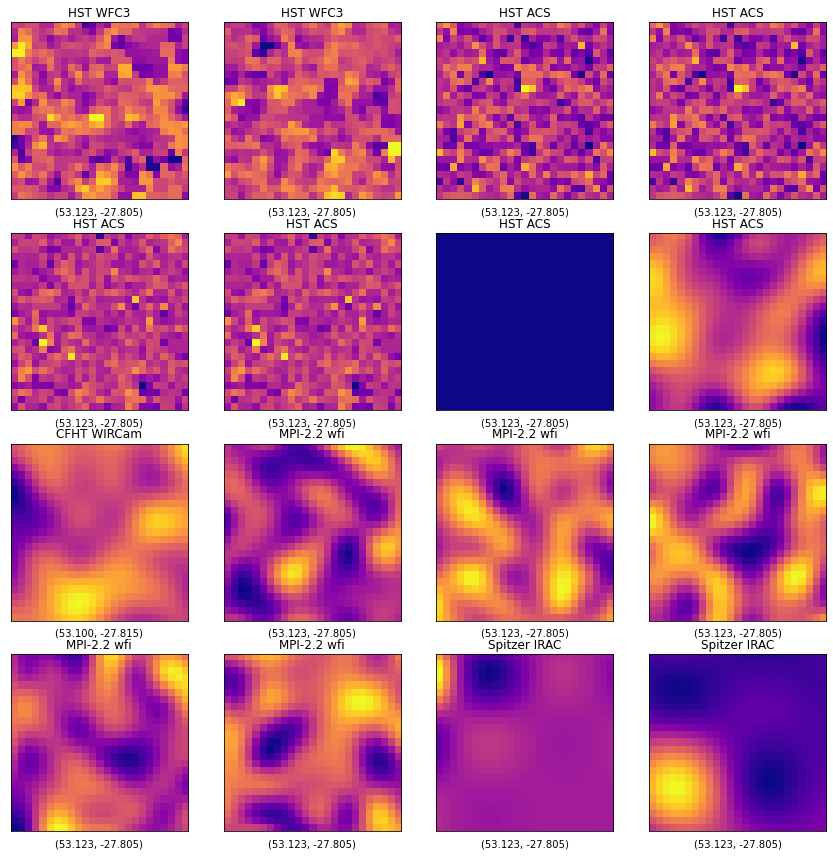

In [87]:
from matplotlib import colors, cm
fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize=(12,12))
j =1
for i in range(1, len(ax.flatten())+1):
    h = hdulist[0][j]
    im = h.data
    #print out RA, DEC of each pointing, to make sure they're all aligned
    ra0 = h.header['CRVAL1']
    dec0 = h.header['CRVAL2']
    if not np.sum(im):
        j += 1
        im = hdulist[0][j].data
    ax.flatten()[i-1].imshow(im, cmap = cm.plasma)
    ax.flatten()[i-1].set_xticks([]); ax.flatten()[i-1].set_yticks([])
    ax.flatten()[i-1].set_title('%s %s' % (h.header['TELESCOP'], h.header['INSTRUME']))
    ax.flatten()[i-1].set_xlabel('(%0.3f, %0.3f)' % (ra0, dec0))
    j+=1

plt.tight_layout(h_pad = 0)

Ok, this image is really blurry :) Let's try something a little closer.

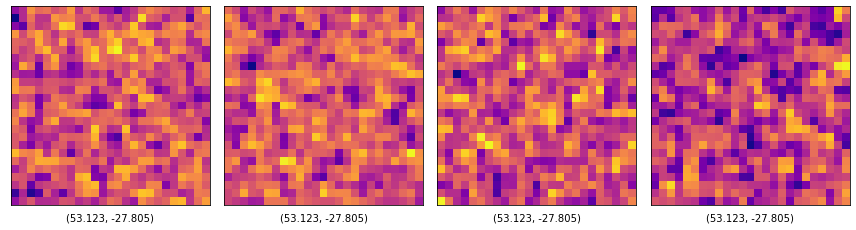

In [96]:
def plot_gal(z, z_target):
    ztarg = np.argmin(abs(z-z_target))
    data[ztarg]

    ra, dec = data[ztarg][raind], data[ztarg][decind]
    cutout_coord = SkyCoord(ra, dec, unit="deg")
    hdulist = Zcut.get_cutouts(coordinates=cutout_coord, size=25)

    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(12,12))
    j =1
    for i in range(1, len(ax.flatten())+1):
        h = hdulist[0][j]
        im = h.data
        #print out RA, DEC of each pointing, to make sure they're all aligned
        ra0 = h.header['CRVAL1']
        dec0 = h.header['CRVAL2']
        if not np.sum(im):
            j += 1
            im = hdulist[0][j].data
        ax.flatten()[i-1].imshow(im, cmap = cm.plasma)
        ax.flatten()[i-1].set_xticks([]); ax.flatten()[i-1].set_yticks([])
        ax.flatten()[i-1].set_xlabel('(%0.3f, %0.3f)' % (ra0, dec0))
        try:
            ax.flatten()[i-1].set_title('%s %s' % (h.header['TELESCOP'], h.header['INSTRUME']))
        except KeyError:
            print()
        j+=1

    plt.tight_layout(h_pad = 0)

plot_gal(z, 6)

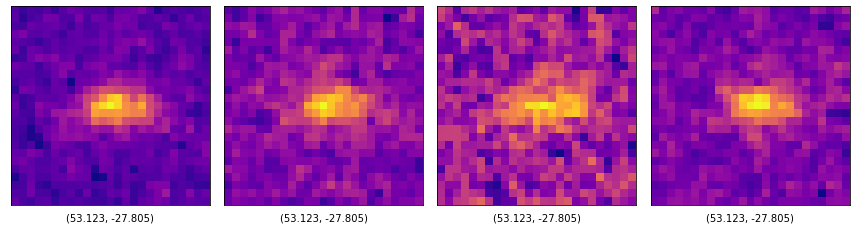

In [97]:
plot_gal(z, 3)

### Concluding thoughts
You can see now how much harder it is to see higher redshift objects with even the deepest HST surveys. What would make a high-z galaxy particularly interesting to observe with JWST? I.e. what properties would you want to pull from ZMAST or Astroquery that would allow you to pick targets?

## About this Notebook
This notebook was developed on behalf of ScienceBetter for the Mikulski Archive at the Space Telescope Science Institute. For additional support, please email `archive@stsci.edu`. 

**Author:** Urmila Chadayammuri, postdoctoral fellow, Center for Astrophysics | Harvard & Smithsonian. 

**Updated On:** 2022-09-22

## Citations
Provide your reader with guidelines on how to cite open source software and other resources in their own published work.

```
If you use `astropy` or `lightkurve` for published research, please cite the
authors. Follow these links for more information about citing `astropy` and
`lightkurve`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)

```

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 